# Applied Data Science Capstone Project

<h2> Incindents of the State of Seattle </h2>

Before anything, import all the libaries that you will use along this project:

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline 
import matplotlib as mpl
import matplotlib.pyplot as plt
import folium

'/resources/labs/ADSC101EN/Capstone-Project/Scripts'

Also, to acces the data, it is usefull to know the path where you are working:

In [ ]:
import os
os.getcwd()

In [2]:
df_traffic = pd.read_csv("Data-Collisions.csv")
df_traffic100 = df_traffic.head(100)
coldf = len(df_traffic100.columns)
pd.set_option("display.max_columns", coldf)
df_traffic.columns

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3072: DtypeWarning: Columns (33) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Index(['SEVERITYCODE', 'X', 'Y', 'OBJECTID', 'INCKEY', 'COLDETKEY', 'REPORTNO',
       'STATUS', 'ADDRTYPE', 'INTKEY', 'LOCATION', 'EXCEPTRSNCODE',
       'EXCEPTRSNDESC', 'SEVERITYCODE.1', 'SEVERITYDESC', 'COLLISIONTYPE',
       'PERSONCOUNT', 'PEDCOUNT', 'PEDCYLCOUNT', 'VEHCOUNT', 'INCDATE',
       'INCDTTM', 'JUNCTIONTYPE', 'SDOT_COLCODE', 'SDOT_COLDESC',
       'INATTENTIONIND', 'UNDERINFL', 'WEATHER', 'ROADCOND', 'LIGHTCOND',
       'PEDROWNOTGRNT', 'SDOTCOLNUM', 'SPEEDING', 'ST_COLCODE', 'ST_COLDESC',
       'SEGLANEKEY', 'CROSSWALKKEY', 'HITPARKEDCAR'],
      dtype='object')

In [3]:
Severity_Code ={
    0 : "Unknown",
    1 : "Prop damage",
    2 : "Injury",
    2.5 : "Serious injury",
    3 : "Fatality"
}
Severity = pd.DataFrame(Severity_Code, index=["Severity"])
Severity

,0.0,1.0,2.0,2.5,3.0
Severity,Unknown,Prop damage,Injury,Serious injury,Fatality


In [42]:
df_traffic["SEVERITYCODE"].value_counts(normalize=True)

1    0.701099
2    0.298901
Name: SEVERITYCODE, dtype: float64

In [3]:
df_traffic["ST_COLCODE"].replace(" ", None, inplace = True)
df_traffic["ST_COLCODE"] = df_traffic["ST_COLCODE"].astype(float)

In [4]:
# Delete the rows which have NaN values on X, Y and ST_COLCODE
df_traffic.dropna(subset=["ST_COLCODE"], axis=0, inplace=True)
df_traffic.dropna(subset=["X"], axis=0, inplace=True)
df_traffic.dropna(subset=["Y"], axis=0, inplace=True)
# Reset the index after deleting rows.
df_traffic.reset_index(drop=True, inplace=True)
# Changes coordinate columns
df_traffic.rename({'X': 'Y', 'Y': 'X'}, axis=1, inplace=True)

In [45]:
country_grp = df_traffic.groupby(["SEVERITYCODE"]) 
# country_grp.get_group(1) 
country_grp["PERSONCOUNT"].value_counts(normalize=True).loc[2]

PERSONCOUNT
2     0.479012
3     0.231871
4     0.108642
1     0.054286
5     0.051046
0     0.030523
6     0.023395
7     0.010910
8     0.004886
9     0.002224
10    0.001296
11    0.000578
12    0.000333
13    0.000210
17    0.000140
15    0.000123
14    0.000105
16    0.000070
19    0.000035
22    0.000035
34    0.000035
18    0.000018
20    0.000018
23    0.000018
24    0.000018
27    0.000018
28    0.000018
29    0.000018
30    0.000018
32    0.000018
37    0.000018
39    0.000018
48    0.000018
54    0.000018
81    0.000018
Name: PERSONCOUNT, dtype: float64

# Plotting nº accidens per year

First, check the INCDATE with the information of the date of each accident.

In [5]:
df_traffic["INCDATE"].head()

0    2013/03/27 00:00:00+00
1    2006/12/20 00:00:00+00
2    2004/11/18 00:00:00+00
3    2013/03/29 00:00:00+00
4    2004/01/28 00:00:00+00
Name: INCDATE, dtype: object

Change the format of the INCDATE column to a datetime format. Then, create a column with the year of each incident.
<p> Also, you need to set the index to INCDATE column to be able to resample in the future.

In [6]:
df_traffic["INCDATE"] = pd.to_datetime(df_traffic["INCDATE"], format = "%Y-%m-%d") 
df_traffic['Year'] = pd.DatetimeIndex(df_traffic['INCDATE']).year  
df_traffic.set_index("INCDATE", inplace = True)
# df_traffic.reset_index(inplace=True)
df_traffic.sort_index(inplace = True)

Then, resample the data frame, only picking the columns REPORTNO and Year, taking only the count and the mean respectively. Set a new index on Year column.

In [9]:
df_acc = df_traffic.resample("Y").agg({"Year":"mean","REPORTNO":"count"})
df_acc.set_index("Year", inplace = True)

Load the matplotlib necessary and the style and make a bar plot of the new data frame.

In [10]:
# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

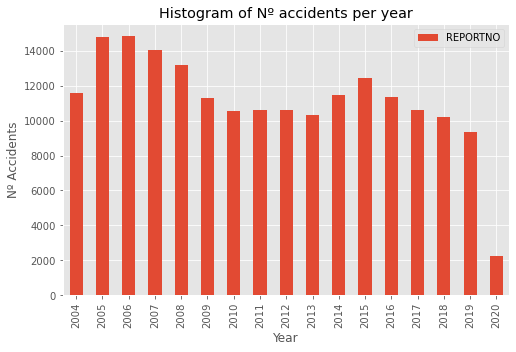

In [11]:
df_acc.plot(kind='bar', figsize=(8, 5))

plt.title('Histogram of Nº accidents per year') # add a title to the histogram
plt.ylabel('Nº Accidents') # add y-label
plt.xlabel('Year') # add x-label

plt.show()

As it can see in the plot, the incidents piked back at 2006, just before the finantial crisis explode on finals of 2007. Then, the incidents reports went down due the decrease of the traffic volume.
<p> After 2013, when the finantial situation started to improve again, a sligthly increase of the incidents can be observed, reaching a pike on 2015, but not as high as 2006.</p>
<p> Due the improvements of the active safety on vehicles and strong regulations on the state of Seattle, the nº of incidents reports start to gradualy decrease, archiveing a new low record on 2019, that it seems to brake it in 2020 due COVID-19 restrictions (last day of data 20-05-2020).

# Map of the accidents

In [18]:
limit = 1000
df_traffic100 = df_traffic.iloc[0:limit, :]

In [19]:
latitude= df_traffic100["X"].mean()
longitude=df_traffic100["Y"].mean()

In [21]:
# define the world map centered around Canada with a low zoom level
Seattle_map = folium.Map(location=[latitude, longitude], zoom_start=10)


In [22]:
# instantiate a feature group for the incidents in the dataframe
incidents = folium.map.FeatureGroup()

# loop through the 100 incidents and add each to the incidents feature group
for lat, lng, in zip(df_traffic100.X, df_traffic100.Y):
    incidents.add_child(
        folium.features.CircleMarker(
            [lat, lng],
            radius=5, # define how big you want the circle markers to be
            color='yellow',
            fill=True,
            fill_color='blue',
            fill_opacity=0.6
        )
    )

# add incidents to map
Seattle_map.add_child(incidents)

In [52]:
df_traffic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 38 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   SEVERITYCODE    100 non-null    int64  
 1   X               96 non-null     float64
 2   Y               96 non-null     float64
 3   OBJECTID        100 non-null    int64  
 4   INCKEY          100 non-null    int64  
 5   COLDETKEY       100 non-null    int64  
 6   REPORTNO        100 non-null    object 
 7   STATUS          100 non-null    object 
 8   ADDRTYPE        99 non-null     object 
 9   INTKEY          36 non-null     float64
 10  LOCATION        98 non-null     object 
 11  EXCEPTRSNCODE   46 non-null     object 
 12  EXCEPTRSNDESC   1 non-null      object 
 13  SEVERITYCODE.1  100 non-null    int64  
 14  SEVERITYDESC    100 non-null    object 
 15  COLLISIONTYPE   95 non-null     object 
 16  PERSONCOUNT     100 non-null    int64  
 17  PEDCOUNT        100 non-null    int6

In [94]:
df_traffic.shape


(189321, 38)